# Time Series Detrending 1
In this project, we impelement different methods to remove the trend in a time series data. The suitable method for detrending depends on the type of the trend in the data, if the trend is deterministic or stochastic.

* **Differentiation:** The detrended data can be obtained by taking the difference between each data point and the previous data point at a particular distance of that (differentiation distance).

* **Simple Moving Average:** It takes the arithmetic mean of a given set of values over a specific period of time in the past.

* **Linear Regression:** If there is a deterministic linear, quadratic, or polynomial trend, we can fit a linear regression model on the data.

* **Hodrick-Prescott (HP)-Filter:** This filter separates a time series into a trend and a cyclical component.

* **Baxter-King Approximate Band-Pass Filter:** This is a symmetric moving average filter where it excludes high and low frequencies.

* **Christiano-Fitzgerald Approximate Band-Pass Filter:** This is a generalization of the Baxter-King filter and can be seen as weighted moving average. However, this filter is asymmetric about time and it uses the entire data.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import statsmodels.tsa.filters.hp_filter as hp
import statsmodels.tsa.filters.bk_filter as bk
import statsmodels.tsa.filters.cf_filter as cf

### Extracting The Dataset
Here, we download the historical data of the Apple daily stock price from the Yahoo repository.

In [2]:
Ticker = 'AAPL'
Interval = '1d'
Start = dt.datetime(2015, 1, 1)
End = dt.datetime(2022, 8, 1)

data_full = yf.download(tickers=Ticker, interval=Interval, start=Start, end=End)


[*********************100%***********************]  1 of 1 completed


### Looking at The Data

In [3]:
data_full

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.644018,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.949757,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.952017,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.287867,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.221066,237458000
...,...,...,...,...,...,...
2022-07-25,154.009995,155.039993,152.279999,152.949997,152.737839,53623900
2022-07-26,152.259995,153.089996,150.800003,151.600006,151.389725,55138700
2022-07-27,152.580002,157.330002,152.160004,156.789993,156.572510,78620700


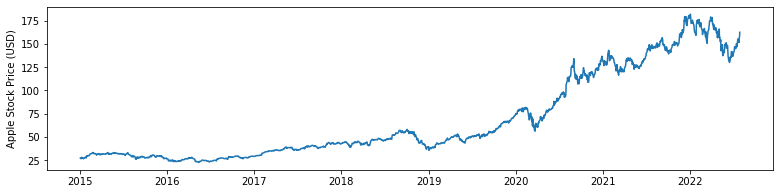

In [4]:
# Plotting the 'Close' price
plt.figure(figsize=(13,3))
plt.plot(data_full['Close'])
plt.ylabel('Apple Stock Price (USD)')
plt.show()

## 1- Differentiation

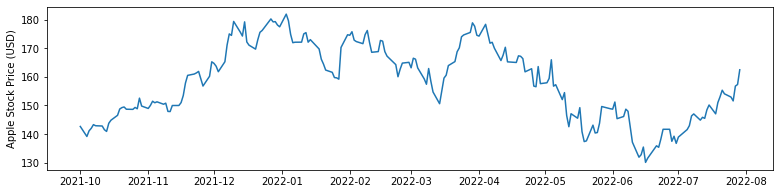

In [5]:
# Selecting part of the main data for analysis
data_main1 = data_full['Close']['2021-10-1':]

# plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main1)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We define the differentiation function as follows:

In [6]:
def Diff(data, distance):
    output = data[distance:].values - data[:-distance].values
    return output 

We apply the function to the data with different values of the differentiation distance and plot the detrended data sets.

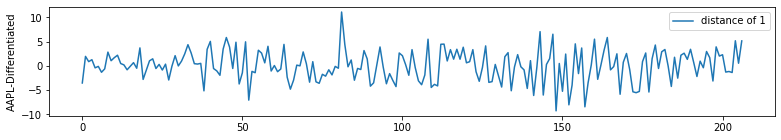

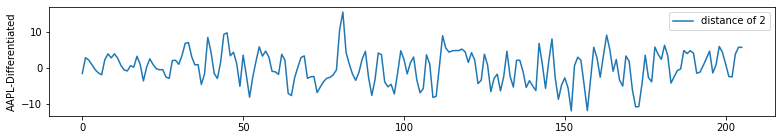

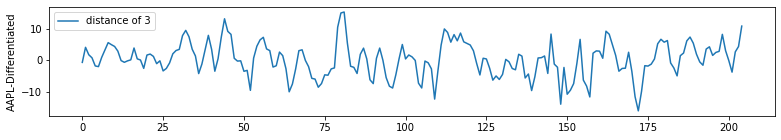

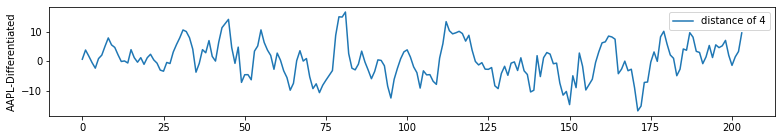

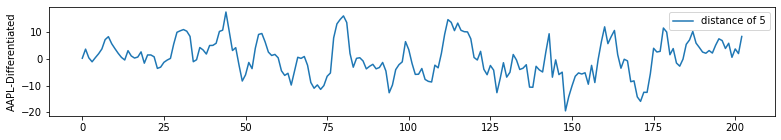

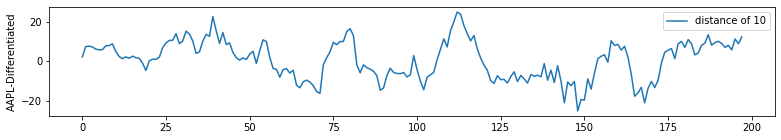

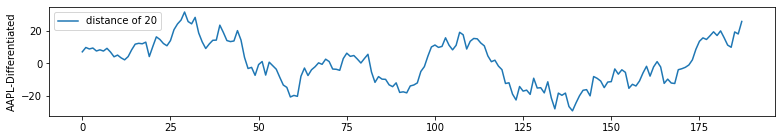

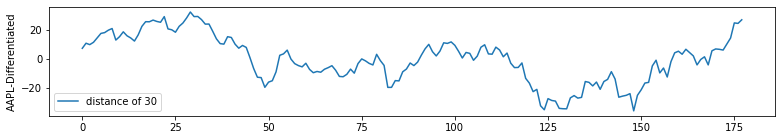

In [7]:
Distances = [1,2,3,4,5,10,20,30]
for i in range(len(Distances)):
    data_main1_detrend = Diff(data_main1, Distances[i])
    plt.figure(figsize=(13,2))
    plt.plot(data_main1_detrend, label=f'distance of {Distances[i]}')
    plt.ylabel('AAPL-Differentiated')
    plt.legend()
    plt.show()

As can be seen in the above figures, different differentiation distances result in different detrended datasets. We can also apply the method multiple times to get the desired results.

## 2- Linear Regression
### 2-1: A Linear Trend
When there is an obvious linear trend in the data, we can fit a linear regression model on the data and subtract the values of the model prediction from the data to get a stationary data.

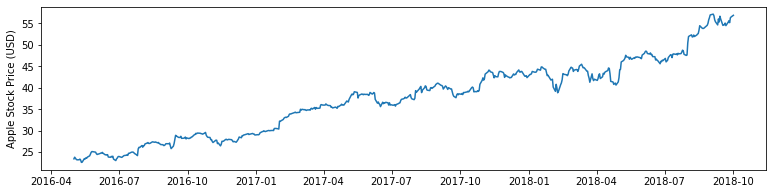

In [8]:
# Selecting part of the main data with an obvious linear trend for analysis
data_main21 = data_full['Close']['2016-5-1':'2018-10-1']

# plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main21)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We fit a linear regression model on the data considering the data values as the target variable and the data point numbers as the attribute variable.

In [9]:
Y = data_main21.values
X = np.arange(1, len(data_main21)+1, 1)

Y = Y.reshape(len(Y), 1)
X = X.reshape(len(X), 1)

model_lr = lm.LinearRegression()
model_lr.fit(X, Y)

LinearRegression()

We extract the predictions of the model as follows:

In [10]:
Y_pred = model_lr.predict(X)

Now, we plot the fitted linear trend together with the real data values. 

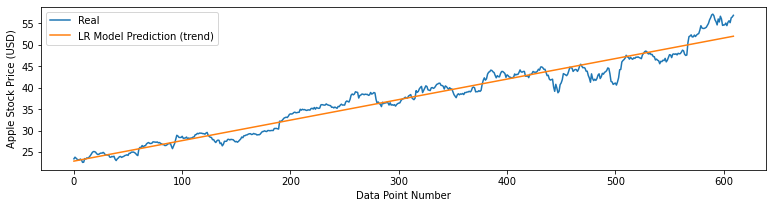

In [11]:
plt.figure(figsize=(13,3))
plt.plot(Y, label='Real')
plt.plot(Y_pred, label='LR Model Prediction (trend)')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('Apple Stock Price (USD)')
plt.show()

In order to get the detrended data, we subtract the real data values from the LR model predictions. 

In [12]:
data_main21_detrend = Y - Y_pred

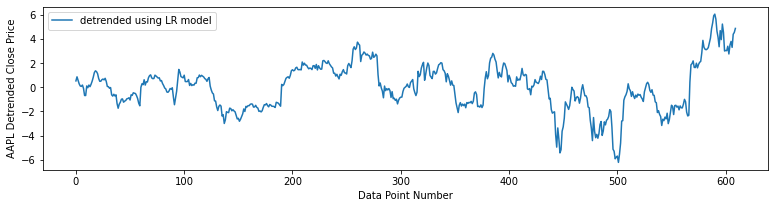

In [13]:
# plotting the detrended data
plt.figure(figsize=(13,3))
plt.plot(data_main21_detrend, label='detrended using LR model')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended Close Price')
plt.show()

As can be seen in the above figure, the data got one step closer to be stationary.

### 2-2: A Polynomial Trend
When there is an obvious quadratic or polynomial trend in the data, we can add more attribute variables built from the main one (the real data) and fit a linear regression on the new data.  

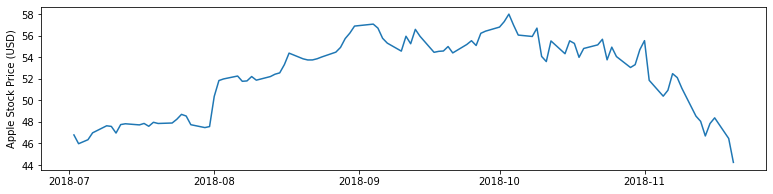

In [14]:
# Selecting part of the main data with a polynomial trend for analysis
data_main22 = data_full['Close']['2018-7-1':'2018-11-20']

# Plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main22)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We define our desired new attribute variables and fit a linear regression model.

In [15]:
Y = data_main22.values
X = np.arange(1, len(data_main22)+1, 1)

Y = Y.reshape(len(Y), 1)
X = X.reshape(len(X), 1)

X = np.concatenate((X**2, X), axis=1) # considering the quadratic trend in the data, we use x^2 values together with x.

model_lr = lm.LinearRegression()
model_lr.fit(X, Y)

LinearRegression()

We extract the model predictions.

In [16]:
Y_pred = model_lr.predict(X)

We plot the fitted polynomial trend together with the real values of the data.

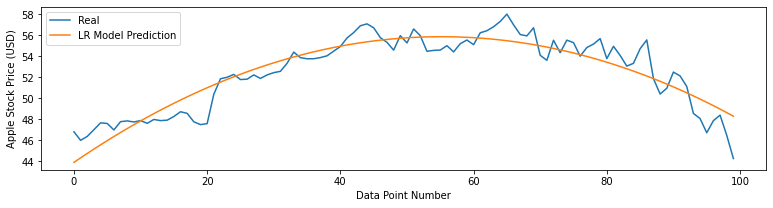

In [17]:
plt.figure(figsize=(13,3))
plt.plot(Y, label='Real')
plt.plot(Y_pred, label='LR Model Prediction')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We simply subtract the trend from the real data to get the detrended data.

In [18]:
data_main22_detrend = Y - Y_pred

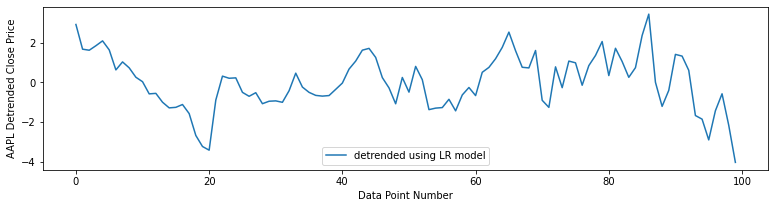

In [19]:
# plotting the detrended data
plt.figure(figsize=(13,3))
plt.plot(data_main22_detrend, label='detrended using LR model')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended Close Price')
plt.show()

## 3- Moving Average
Moving average can be used as a mean to detrend the data.

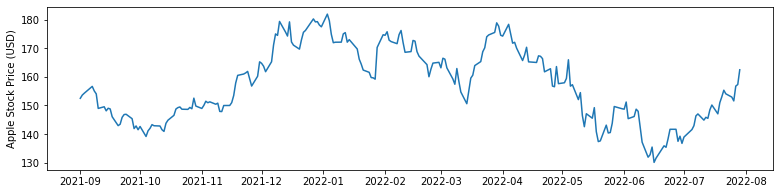

In [20]:
# Selecting part of the main data for analysis
data_main3 = data_full['Close']['2021-9-1':]

# Plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main3)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We can clearly see both positive and negative trends in different parts of the data. 

We define a function for calculating the simple moving averages as follows:

In [21]:
def SMA(data, length):
    num = len(data) - length + 1
    output = np.zeros(num)
    for i in range(num):
        output[i] = np.mean(data[i:i+length])
    return output

We apply the method to the data.

In [22]:
length = 5
data_main3_SMA = SMA(data_main3, length)

We plot the calculated moving averages together with the real values of the data. 

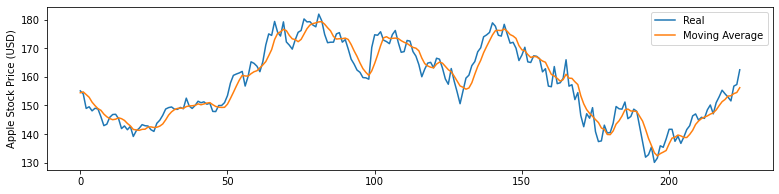

In [23]:
plt.figure(figsize=(13,3))
plt.plot(data_main3[length-1:].values, label='Real')
plt.plot(data_main3_SMA, label='Moving Average')
plt.ylabel('Apple Stock Price (USD)')
plt.legend()
plt.show()

The behavior of the method highly depends on the lenght of taking averages. A larger 'length' results in a smoother trend.

We can simply obtain the stationary data by subtracting the moving averages from the real data.

In [24]:
data_main3_detrend = data_main3[length-1:].values - data_main3_SMA

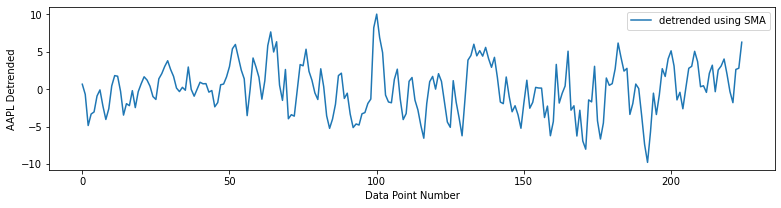

In [25]:
# Plotting the detrended data 
plt.figure(figsize=(13,3))
plt.plot(data_main3_detrend, label='detrended using SMA')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended')
plt.show()

## 4. Hodrick-Prescott Filter

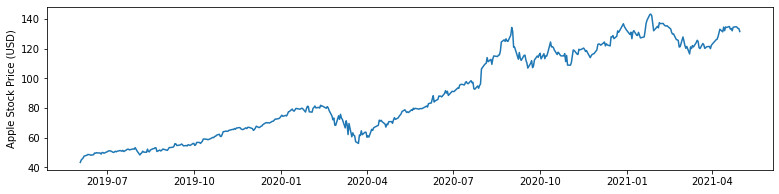

In [26]:
# Selecting part of the main data for analysis
data_main4 = data_full['Close']['2019-6-1':'2021-5-1']

# Plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main4)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We use the hp-filter from the statsmodels library. 'lamb' is the Hodrick-Prescott smoothing parameter. When its value is small, the model captures the small oscilations in the data and when it is large, the filter shows a linear behavior. 

In [27]:
hp_cycle, hp_trend = hp.hpfilter(data_main4.values, lamb=10000)

We plot the extracted trend by the hp-filter together with the real values of the data.

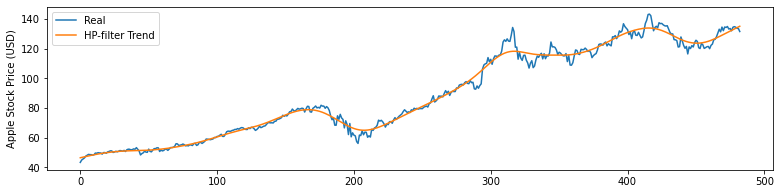

In [28]:
plt.figure(figsize=(13,3))
plt.plot(data_main4.values, label='Real')
plt.plot(hp_trend, label='HP-filter Trend')
plt.ylabel('Apple Stock Price (USD)')
plt.legend()
plt.show()

We simply subtract the trend from the real data to get the detrended data that equals the returned 'hp_cycle' by the hpfilter function. 

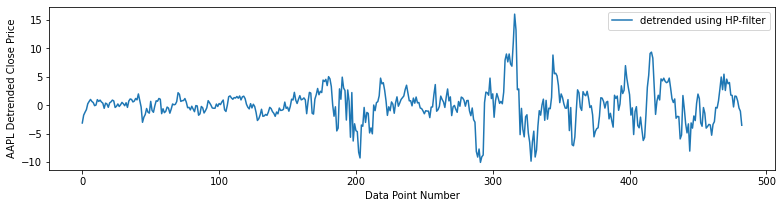

In [29]:
# plotting the detrended data 
plt.figure(figsize=(13,3))
plt.plot(hp_cycle, label='detrended using HP-filter')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended Close Price')
plt.show()

## 5- Baxter-King Approximate Band-Pass Filter

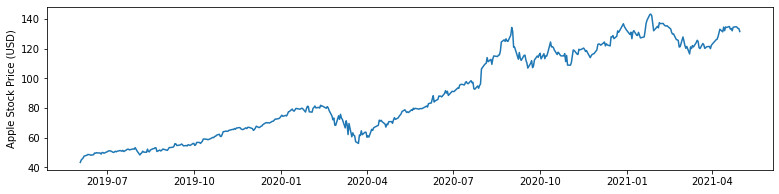

In [30]:
# Selecting part of the main data for analysis
data_main5 = data_full['Close']['2019-6-1':'2021-5-1']

# Plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main5)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We use the Baxter-King filter from the statsmodels library. The minimum (low) and maximum (high) periods for oscillations of this band-pass filter together with the lead-lag length (K) of the filter are the required arguments. We lose K observations on both ends. The filter eliminates any trend in the series and output the stationary data.

In [31]:
bk_cycle = bk.bkfilter(data_main5.values, low=6, high=32, K=12)

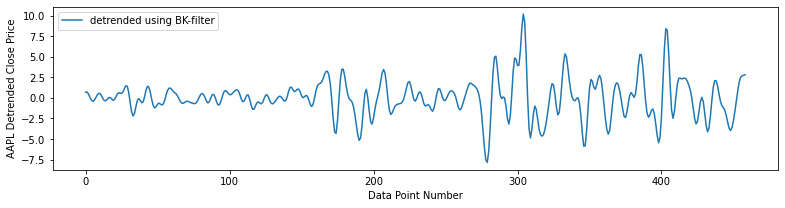

In [32]:
# plotting the detrended data 
plt.figure(figsize=(13,3))
plt.plot(bk_cycle, label='detrended using BK-filter')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended Close Price')
plt.show()

## 6- Christiano-Fitzgerald Approximate Band-Pass Filter

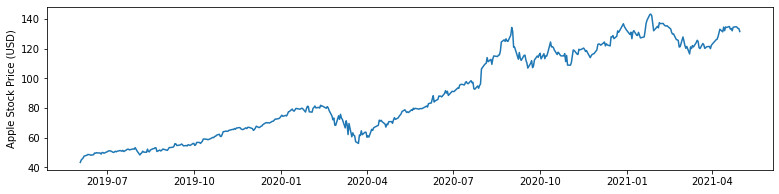

In [33]:
# Selecting part of the main data for analysis
data_main6 = data_full['Close']['2019-6-1':'2021-5-1']

# Plotting the data
plt.figure(figsize=(13,3))
plt.plot(data_main6)
plt.ylabel('Apple Stock Price (USD)')
plt.show()

We use the Christiano-Fitzgerald filter from the statsmodels library. The minimum (low) and maximum (high) periods for oscillations of this band-pass filter are the required arguments. 'drift' determines whether or not to remove a trend from the data.

In [34]:
cf_cycle, cf_trend  = cf.cffilter(data_main6.values, low=6, high=32, drift=False)

We plot the trend in the data extracted from the CF-filter.

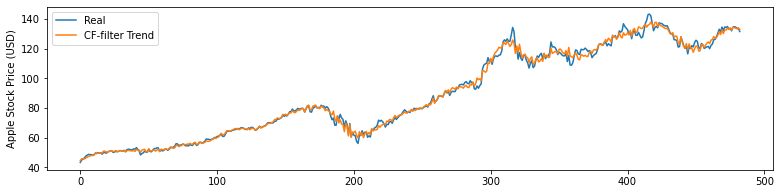

In [35]:
plt.figure(figsize=(13,3))
plt.plot(data_main6.values, label='Real')
plt.plot(cf_trend, label='CF-filter Trend')
plt.ylabel('Apple Stock Price (USD)')
plt.legend()
plt.show()

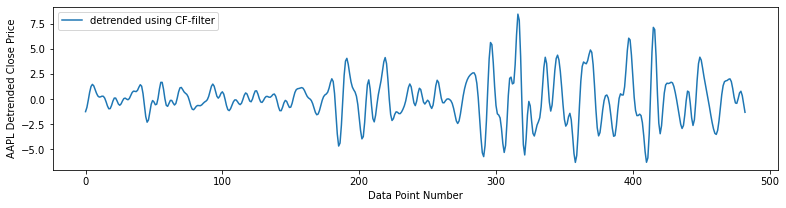

In [36]:
# plotting the detrended data 
plt.figure(figsize=(13,3))
plt.plot(cf_cycle, label='detrended using CF-filter')
plt.legend()
plt.xlabel('Data Point Number')
plt.ylabel('AAPL Detrended Close Price')
plt.show()

------
#### END